In [1]:
from sklearn import datasets

import numpy as np
import pandas as pd
import math
import itertools
import time

import matplotlib.pyplot as plt

colors = {-1: 'black', 0: 'blue', 1:'orange', 2:'green', 3:'red', 4:'purple',
         5:'brown', 6:'pink', 7:'gray', 8:'olive', 9:'cyan', 10:'forestgreen'}

datasetTimeStart = time.perf_counter()

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

df = pd.DataFrame(noisy_circles[0], columns = ['x1', 'x2'])

df['y'] = noisy_circles[1]

df['visited'] = 0
df['cluster'] = -1
df['neighbors'] = [ [] for _ in range(n_samples) ]

datasetTimeStop = time.perf_counter()

print("Dataset make_circles time: {0:5.4}\n".format((datasetTimeStop - datasetTimeStart)*100))

print(df.head())

Dataset make_circles time: 0.2895

         x1        x2  y  visited  cluster neighbors
0 -0.959182  0.084955  0        0       -1        []
1 -0.087372 -0.427691  1        0       -1        []
2  0.629093 -0.014742  1        0       -1        []
3 -1.009220 -0.340407  0        0       -1        []
4 -0.269065  0.457991  1        0       -1        []


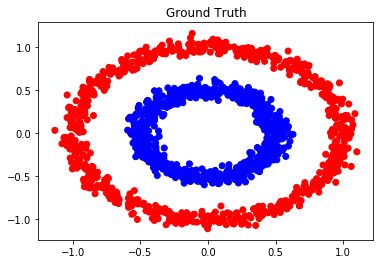

In [2]:
def plot_graph(df, title, label):
    fig, ax = plt.subplots()

    plt.title(title)
    ax.scatter(df['x1'], df['x2'], c=df[label].map(colors))

    plt.show()
    
plot_graph(df, "Ground Truth", "y")

In [3]:
def get_distances(df):
    print("get_distances")
    
    getDistancesTimeStart = time.perf_counter()
    
    numPoints = df.shape[0]
    
    distanceArray = np.zeros([numPoints, numPoints], dtype = float)
    
    for i in range(numPoints):
        for j in range(i, numPoints):
            if i == j:
                continue
                
            distance = math.sqrt(math.pow(df.iloc[i]['x1'] - df.iloc[j]['x1'], 2) + 
                                 math.pow(df.iloc[i]['x2'] - df.iloc[j]['x2'], 2))
            
            distanceArray[i, j] = distance
            distanceArray[j, i] = distance
            
    getDistancesTimeStop = time.perf_counter()
    
    print("get_distances time: {0:5.4}\n".format((getDistancesTimeStop - getDistancesTimeStart)*100))
    
    return distanceArray

def count_neighbors(df, distanceArray, epsilon):
    print("count_neighbors")
    
    countNeighborsTimeStart = time.perf_counter()
    
    for i in range(df.shape[0]):
        row = distanceArray[i, :]
    
        nestedList = np.argwhere(row < epsilon).tolist()
        
        flatList = list(itertools.chain.from_iterable(nestedList))
        
        df.iloc[i]['neighbors'].extend(flatList)
        
    countNeighborsTimeStop = time.perf_counter()
    
    print("count_neighbors time: {0:5.4}\n".format((countNeighborsTimeStop - countNeighborsTimeStart)*100))


        
def DBSCAN(df, epsilon, minPts):
    clusterCount = 0
    
    df['neighbors'] = [ [] for _ in range(n_samples) ]
    
    distanceArray = get_distances(df)
        
    count_neighbors(df, distanceArray, epsilon)
    
    print("Running DBSCAN")
    
    dbscanTimeStart = time.perf_counter()
    
    while 0 in df['visited'].values:
        index = df[df.visited == 0].first_valid_index()
        
        # mark datapoint as visited
        df.at[index, 'visited'] = 1
        
        # check if this datapoint has enough neighbors
        if len(df.iloc[index]['neighbors']) < minPts:
            continue
            
        # add datapoint to a new cluster
        df.at[index, 'cluster'] = clusterCount
        print(df.iloc[index]['cluster'])
        # queue of neighbors to check
        queue = []
        
        # add current datapoint's neighbors to queue
        for item in df.iloc[index]['neighbors']:
            if df.iloc[item]['visited'] == 0:
                queue.append(item)
        
        while len(queue) > 0:
            index = queue.pop(0)
            
            if df.iloc[index]['visited'] == 1:
                continue
                
            df.at[index, 'visited'] = 1
            
            if len(df.iloc[index]['neighbors']) >= minPts:
                for item in df.iloc[index]['neighbors']:
                    if df.iloc[item]['visited'] == 0:
                        queue.append(item)
                
            df.at[index, 'cluster'] = clusterCount
            
        clusterCount += 1
        
    print("Finished")
        
    dbscanTimeStop = time.perf_counter()
    
    print("dbscan time: {0:5.4}\n".format((dbscanTimeStop - dbscanTimeStart)*100))


DBSCAN(df, .2, 10)

get_distances
get_distances time: 5.172e+04

count_neighbors
count_neighbors time: 22.42

Running DBSCAN
0
1
Finished
dbscan time: 1.651e+03



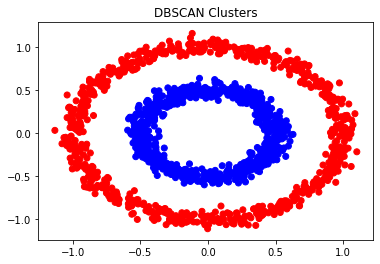

In [4]:
plot_graph(df, "DBSCAN Clusters", "cluster")

In [5]:
print(df.head(100))

          x1        x2  y  visited  cluster  \
0  -0.959182  0.084955  0        1        0   
1  -0.087372 -0.427691  1        1        1   
2   0.629093 -0.014742  1        1        1   
3  -1.009220 -0.340407  0        1        0   
4  -0.269065  0.457991  1        1        1   
..       ...       ... ..      ...      ...   
95 -0.026099  0.488250  1        1        1   
96 -0.661233 -0.818726  0        1        0   
97 -0.356642  0.991827  0        1        0   
98 -0.076730  0.499124  1        1        1   
99 -0.835546  0.584757  0        1        0   

                                            neighbors  
0   [0, 35, 106, 112, 148, 169, 214, 233, 249, 288...  
1   [1, 53, 65, 89, 102, 127, 128, 180, 187, 194, ...  
2   [2, 67, 74, 87, 116, 133, 150, 153, 185, 209, ...  
3   [3, 62, 84, 105, 111, 121, 162, 175, 181, 260,...  
4   [4, 13, 41, 52, 58, 66, 78, 86, 98, 140, 155, ...  
..                                                ...  
95  [37, 58, 66, 79, 85, 93, 95, 98, 126, 1